In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#machine learning for later
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [99]:
train_df = pd.read_csv("train.csv")

## Initial Data Discovery

In [100]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [101]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Nulls in Age, Cabin and Embarked which will need to be dealt with. Have a mix of numerical and categorical data. Describe them separately.

In [102]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [103]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Johnston, Mr. Andrew G",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [104]:
train_df[['Sex','Survived']].groupby('Sex', as_index=False).mean().sort_values(by='Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [105]:
train_df[['Embarked','Survived']].groupby('Embarked', as_index=False).mean().sort_values(by='Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Since only two values are missing the easiest thing to do would be to fill those with the most frequent value. Which is 'S'

In [106]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [107]:
survived = train_df[train_df['Survived'] == 1]
died = train_df[train_df['Survived'] == 0]

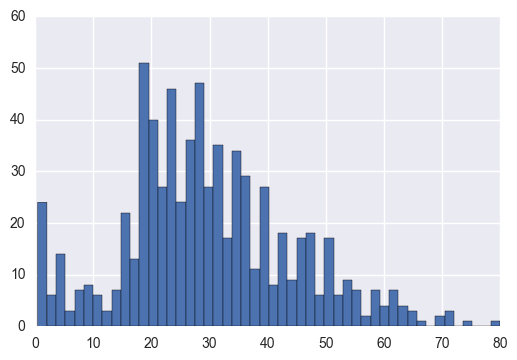

In [108]:
train_df['Age'].hist(bins = 50)
plt.show()

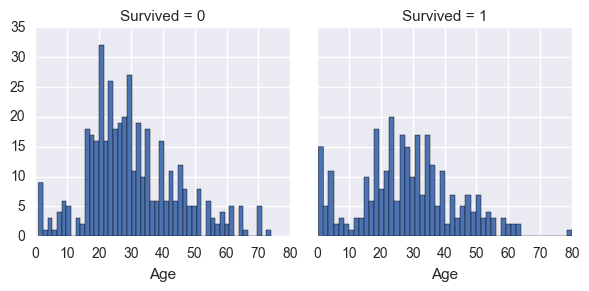

In [109]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=50)

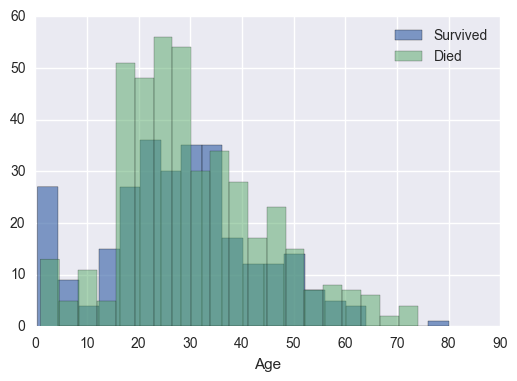

In [110]:
survived['Age'].hist(bins = 20, alpha = 0.7)
died['Age'].hist(bins = 20, alpha = 0.5 )
labels = ['Survived', 'Died']
plt.legend(labels)
plt.xlabel('Age')
plt.show()

Seems to be a decent correlation between age and survival will need to impute the missing values here. Can do median imputation firstly.

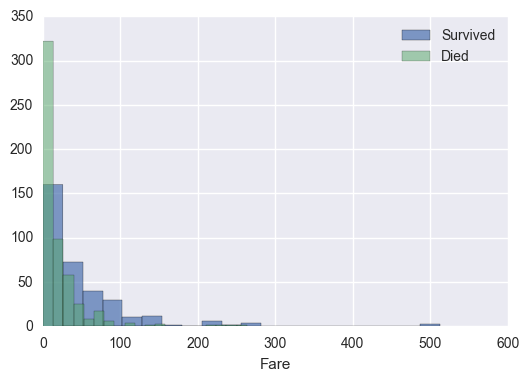

In [111]:
survived['Fare'].hist(bins = 20, alpha = 0.7)
died['Fare'].hist(bins = 20, alpha = 0.5 )
labels = ['Survived', 'Died']
plt.legend(labels)
plt.xlabel('Fare')
plt.show()

In [112]:
corr_matrix = train_df.corr()

In [113]:
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

High correlations with Pclass and Fare. Not much with Parch and SibSp. What if we combine the number of parents/children (Parch) and the number of siblings/spouses (SibSp) into a family size? 

In [114]:
train = train_df.copy()

In [115]:
train['FamilySize'] = train['Parch'] + train['SibSp'] + 1

In [116]:
train['FamilySize'].corr(train['Survived'])

0.016638989282745251

Not higher than them individually. 

In [117]:
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1

In [118]:
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [119]:
train['IsAlone'].corr(train['Survived'])

-0.20336708569989206

This is a much higher correlation

## Data Cleaning and Prep

In [120]:
#filling age with median
train['Age'].fillna(train['Age'].median(), inplace = True)

In [121]:
#filling Embarked with most frequent 'S'
train['Embarked'].fillna('S', inplace = True)

In [122]:
#dropping useless columns, ticket, cabin, familysize, sibsp,parch

In [123]:
train.drop(['SibSp', 'Parch', 'Ticket', 'Cabin','FamilySize'], axis = 1, inplace = True)

In [124]:
train.drop('PassengerId', axis = 1, inplace = True)

In [125]:
train.drop('Name', axis = 1, inplace = True)

In [126]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,male,22.0,7.2500,S,0
1,1,1,female,38.0,71.2833,C,0
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,0
4,0,3,male,35.0,8.0500,S,1


Need to convert Sex and Embarked to numerical value. And probably could convert Age to int.

In [127]:
train['Age'] = train['Age'].astype(int)

In [128]:
le = LabelEncoder()

In [129]:
train['Sex'] = le.fit_transform(train['Sex'])

In [130]:
train['Embarked'] = le.fit_transform(train['Embarked'])

In [131]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,1,22,7.2500,2,0
1,1,1,0,38,71.2833,0,0
2,1,3,0,26,7.9250,2,1
3,1,1,0,35,53.1000,2,0
4,0,3,1,35,8.0500,2,1


## First Model Implementation

In [132]:
X_train = train.drop('Survived', axis =1 )
y_train = train['Survived']

### Logistic Regression

In [133]:
log_reg = LogisticRegression()

In [134]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [135]:
log_reg.score(X_train, y_train)

0.7912457912457912

In [136]:
log_reg_cv_score  = cross_val_score(log_reg, X_train, y_train, cv = 3)
log_reg_cv_score

array([ 0.78451178,  0.77777778,  0.77777778])

In [137]:
np.mean(log_reg_cv_score)

0.78002244668911336

### Random Forest

In [138]:
random_forest = RandomForestClassifier()

In [139]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [140]:
random_forest.score(X_train, y_train)

0.96520763187429859

In [141]:
rf_cv_score = cross_val_score(random_forest, X_train, y_train, cv = 3)
rf_cv_score

array([ 0.75420875,  0.81818182,  0.81481481])

In [142]:
np.mean(rf_cv_score)

0.79573512906846233

### KNN

In [143]:
knn = KNeighborsClassifier()

In [144]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [145]:
knn.score(X_train, y_train)

0.8058361391694725

In [146]:
knn_cv_score = cross_val_score(knn, X_train, y_train, cv = 3)
knn_cv_score

array([ 0.65993266,  0.71380471,  0.71043771])

In [147]:
np.mean(knn_cv_score)

0.69472502805836134

### SVM

In [148]:
svc = SVC()

In [149]:
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [150]:
svc.score(X_train, y_train)

0.89450056116722787

In [151]:
svc_cv_score = cross_val_score(svc, X_train, y_train, cv = 3)
svc_cv_score

array([ 0.64646465,  0.67676768,  0.72053872])

In [152]:
np.mean(svc_cv_score)

0.68125701459034804

In [153]:
model_rank = pd.DataFrame(
    {'Model' : ['Logistic Regression', 'Random Forest', 'KNN', 'SVM']
        ,
     'CV Score': [np.mean(log_reg_cv_score),np.mean(rf_cv_score)
                  ,np.mean(knn_cv_score),np.mean(svc_cv_score)]
     }    
)

In [154]:
model_rank.sort_values(by='CV Score', ascending = False)

,CV Score,Model
1,0.795735,Random Forest
0,0.780022,Logistic Regression
2,0.694725,KNN
3,0.681257,SVM


Random Forest and Logistic Regression are best. Can try and implement bias/variance checks to see if additional features etc would help and then can refine the model using gridsearch. Perhaps instead of pure numerical Age (and Fare) can put them into groups, e.g. 0-16 years old etc. And can also look at getting some features out of the 'Name' field.

## Second Data Cleaning and Prep

In [155]:
train2 = train_df.copy()

In [156]:
train2['FamilySize'] = train2['Parch'] + train2['SibSp'] + 1
train2['IsAlone'] = 0
train2.loc[train2['FamilySize'] == 1, 'IsAlone'] = 1
train2['Embarked'].fillna('S', inplace = True)
train2.drop(['SibSp', 'Parch', 'Ticket', 'Cabin','FamilySize','PassengerId', 'Name'], axis = 1, inplace = True)

In [157]:
le = LabelEncoder()
train2['Sex'] = le.fit_transform(train2['Sex'])

In [158]:
train2.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,1,22.0,7.2500,S,0
1,1,1,0,38.0,71.2833,C,0
2,1,3,0,26.0,7.9250,S,1
3,1,1,0,35.0,53.1000,S,0
4,0,3,1,35.0,8.0500,S,1


In [159]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [160]:
embarked_1hot = pd.DataFrame(lb.fit_transform(train2['Embarked']), columns = ['C', 'S', 'Q'])

In [161]:
train2[['C', 'Q', 'S']] = embarked_1hot

In [162]:
Pclass_1hot = pd.DataFrame(lb.fit_transform(train2['Pclass']), columns = ['1st', '2nd', '3rd'])

In [163]:
train2[['1st', '2nd', '3rd']] = Pclass_1hot

In [164]:
train2.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,C,Q,S,1st,2nd,3rd
0,0,3,1,22.0,7.2500,S,0,0,0,1,0,0,1
1,1,1,0,38.0,71.2833,C,0,1,0,0,1,0,0
2,1,3,0,26.0,7.9250,S,1,0,0,1,0,0,1
3,1,1,0,35.0,53.1000,S,0,0,0,1,1,0,0
4,0,3,1,35.0,8.0500,S,1,0,0,1,0,0,1


In [165]:
guess_ages = np.zeros((2,3))
guess_ages

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = train2[(train2['Sex'] == i) & \
                              (train['Pclass'] == j+1)]['Age'].dropna()

        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5


In [166]:
for i in range(0, 2):
    for j in range(0, 3):
        train2.loc[ (train2.Age.isnull()) & (train2.Sex == i) & (train2.Pclass == j+1),'Age'] = guess_ages[i,j]

In [167]:
train2.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,C,Q,S,1st,2nd,3rd
0,0,3,1,22.0,7.2500,S,0,0,0,1,0,0,1
1,1,1,0,38.0,71.2833,C,0,1,0,0,1,0,0
2,1,3,0,26.0,7.9250,S,1,0,0,1,0,0,1
3,1,1,0,35.0,53.1000,S,0,0,0,1,1,0,0
4,0,3,1,35.0,8.0500,S,1,0,0,1,0,0,1


In [168]:
train_new = train2.drop(['Pclass', 'Embarked'], axis = 1)

In [169]:
train_new.head()

,Survived,Sex,Age,Fare,IsAlone,C,Q,S,1st,2nd,3rd
0,0,1,22.0,7.2500,0,0,0,1,0,0,1
1,1,0,38.0,71.2833,0,1,0,0,1,0,0
2,1,0,26.0,7.9250,1,0,0,1,0,0,1
3,1,0,35.0,53.1000,0,0,0,1,1,0,0
4,0,1,35.0,8.0500,1,0,0,1,0,0,1


In [170]:
train_new.head()

,Survived,Sex,Age,Fare,IsAlone,C,Q,S,1st,2nd,3rd
0,0,1,22.0,7.2500,0,0,0,1,0,0,1
1,1,0,38.0,71.2833,0,1,0,0,1,0,0
2,1,0,26.0,7.9250,1,0,0,1,0,0,1
3,1,0,35.0,53.1000,0,0,0,1,1,0,0
4,0,1,35.0,8.0500,1,0,0,1,0,0,1


In [171]:
corr_matrix = train_new.corr()

In [172]:
X_train_new = train_new.drop('Survived', axis =1 )
y_train_new = train_new['Survived']

## Remodelling

### Logistic Regression

In [173]:
log_reg_new = LogisticRegression()

In [174]:
log_reg_new.fit(X_train_new, y_train_new)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [175]:
log_reg_cv_score_new = cross_val_score(log_reg_new, X_train_new, y_train_new, cv = 3)
log_reg_cv_score

array([ 0.78451178,  0.77777778,  0.77777778])

### KNN

In [176]:
knn_new = KNeighborsClassifier()

In [177]:
knn_new.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [178]:
knn_cv_score_new = cross_val_score(knn_new, X_train_new, y_train_new, cv = 3)
knn_cv_score_new

array([ 0.67676768,  0.71380471,  0.71043771])

### SVM

In [179]:
svc_new = SVC()

In [180]:
svc_new.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [181]:
svc_cv_score_new = cross_val_score(svc_new, X_train_new, y_train_new, cv = 3)
svc_cv_score_new

array([ 0.66666667,  0.71043771,  0.7037037 ])

### Decision Tree

In [182]:
decision_tree = DecisionTreeClassifier()

In [183]:
decision_tree.fit(X_train_new, y_train_new)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [184]:
dt_cv_score = cross_val_score(decision_tree, X_train_new, y_train_new, cv=3)
dt_cv_score

array([ 0.75084175,  0.8013468 ,  0.77104377])

### Random Forest

In [185]:
random_forest_new = RandomForestClassifier()

In [186]:
random_forest_new.fit(X_train_new, y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [187]:
rf_cv_score_new = cross_val_score(random_forest_new, X_train_new, y_train_new, cv = 3)
rf_cv_score_new

array([ 0.77104377,  0.79461279,  0.77104377])

In [188]:
new_model_rank = pd.DataFrame(
    {'Model' : ['Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Decision Tree']
        ,
     'CV Score': [np.mean(log_reg_cv_score_new),np.mean(rf_cv_score_new)
                  ,np.mean(knn_cv_score_new),np.mean(svc_cv_score_new), np.mean(dt_cv_score)]
     }    
)

In [189]:
new_model_rank.sort_values(by='CV Score', ascending = False)

,CV Score,Model
0,0.786756,Logistic Regression
1,0.778900,Random Forest
4,0.774411,Decision Tree
2,0.700337,KNN
3,0.693603,SVM


## Grid Search

In [190]:
param_grid = [
{'n_estimators':[3,10,30,300], 'max_features':[2,4,6,7], 'max_depth':[None, 1, 2], 'bootstrap':[False,True]}
]

In [192]:
grid_search = GridSearchCV(random_forest_new, param_grid, cv = 3, scoring = 'accuracy')

In [193]:
grid_search.fit(X_train_new, y_train_new)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'bootstrap': [False, True], 'max_depth': [None, 1, 2], 'max_features': [2, 4, 6, 7], 'n_estimators': [3, 10, 30, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [194]:
grid_search.best_score_

0.80471380471380471

In [195]:
grid_search.best_params_

{'bootstrap': False, 'max_depth': 2, 'max_features': 4, 'n_estimators': 3}

## Cleaning test set

In [ ]:
test_df = pd.read_csv("test.csv")

In [ ]:
test_df.info()

In [ ]:
test_df['Fare'].value_counts().max()

In [ ]:
test2 = test_df.copy()
test2['FamilySize'] = test2['Parch'] + test2['SibSp'] + 1
test2['IsAlone'] = 0
test2.loc[test2['FamilySize'] == 1, 'IsAlone'] = 1
test2['Embarked'].fillna('S', inplace = True)
test2.drop(['SibSp', 'Parch', 'Ticket', 'Cabin','FamilySize','PassengerId', 'Name'], axis = 1, inplace = True)
le = LabelEncoder()
test2['Sex'] = le.fit_transform(test2['Sex'])
embarked_1hot = pd.DataFrame(lb.fit_transform(test2['Embarked']), columns = ['C', 'S', 'Q'])
test2[['C', 'Q', 'S']] = embarked_1hot
Pclass_1hot = pd.DataFrame(lb.fit_transform(test2['Pclass']), columns = ['1st', '2nd', '3rd'])
test2[['1st', '2nd', '3rd']] = Pclass_1hot
for i in range(0, 2):
    for j in range(0, 3):
        test2.loc[ (test2.Age.isnull()) & (test2.Sex == i) & (test2.Pclass == j+1),'Age'] = guess_ages[i,j]
test2['Fare'] = 21

In [ ]:
X_train_new.head()

In [ ]:
X_test_new = test2.drop(['Pclass', 'Embarked'], axis = 1)

In [ ]:
X_test_new.info()

In [ ]:
final_model = grid_search.best_estimator_

In [ ]:
final_predictions = final_model.predict(X_test_new)

In [ ]:
final_predictions_df = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": final_predictions
    })

In [ ]:
final_predictions_df[final_predictions_df['Survived'] == 1]['Survived'].sum() / len(final_predictions_df)

In [ ]:
train_df[train_df['Survived'] ==1]['Survived'].sum() / len(train_df)

In [ ]:
final_predictions_df.to_csv("submissions.csv", index = False)